In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [68]:
df = pd.read_csv('C:\\Local D\\Galeri Belajar\\Project\\ML Zoomcamp 2025\\ml-zoomcamp-2025\\02_regresion\\homework\\data\\car_fuel_efficiency.csv')
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [69]:
columns_to_use = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
df = df[columns_to_use]
df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


# EDA

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

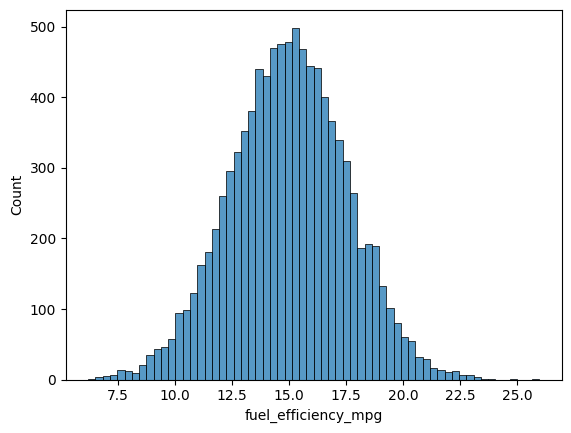

In [70]:
import seaborn as sns

sns.histplot(df.fuel_efficiency_mpg)

Doesn't have long tail

# Q1

In [71]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

# Q2

In [72]:
median = df.horsepower.median()
print(median)

149.0


# Q3

In [73]:
n = len(df)
n_val = int (n*0.2)
n_test = int(n*0.2)
n_train = n - n_val - n_test

In [74]:
n_val, n_test, n_train

(1940, 1940, 5824)

In [75]:
df_val = df.iloc[:n_val]
df_test = df.iloc[n_val:n_val+n_test]
df_train = df.iloc[n_val+n_test:]

# Q4

In [76]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    Xb = np.column_stack([ones, X])
    XTX = Xb.T.dot(Xb)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(Xb.T).dot(y)
    return float(w_full[0]), w_full[1:]

In [77]:
def rmse(y, y_pred):
    err = y_pred - y
    mse = (err ** 2).mean()
    return float(np.sqrt(mse))

In [78]:
# shuffle and split (recommended)
n = len(df)
idx = np.arange(n)
np.random.seed(2)
np.random.shuffle(idx)

In [79]:
df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)

features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
target = 'fuel_efficiency_mpg'

In [80]:
# Option 1: fill horsepower with 0
df_train_0 = df_train.copy()
df_val_0 = df_val.copy()
df_train_0['horsepower'] = df_train_0['horsepower'].fillna(0)
df_val_0['horsepower'] = df_val_0['horsepower'].fillna(0)
# safety: fill other numeric NaNs with 0
df_train_0 = df_train_0.fillna(0)
df_val_0 = df_val_0.fillna(0)

In [81]:
X_train_0 = df_train_0[features].values
y_train = df_train_0[target].values.astype(float)
X_val_0 = df_val_0[features].values
y_val = df_val_0[target].values.astype(float)

In [82]:
w0_0, w_0 = train_linear_regression(X_train_0, y_train)
y_pred_val_0 = w0_0 + X_val_0.dot(w_0)
rmse_0 = round(rmse(y_val, y_pred_val_0), 2)

In [83]:
# Option 2: fill horsepower with train mean (compute mean on training only)
df_train_m = df_train.copy()
df_val_m = df_val.copy()
hp_mean = df_train_m['horsepower'].mean(skipna=True)
if np.isnan(hp_mean):
    hp_mean = 0.0
df_train_m['horsepower'] = df_train_m['horsepower'].fillna(hp_mean)
df_val_m['horsepower'] = df_val_m['horsepower'].fillna(hp_mean)
df_train_m = df_train_m.fillna(0)
df_val_m = df_val_m.fillna(0)

X_train_m = df_train_m[features].values
X_val_m = df_val_m[features].values

w0_m, w_m = train_linear_regression(X_train_m, y_train)  # same y_train (target)
y_pred_val_m = w0_m + X_val_m.dot(w_m)
rmse_m = round(rmse(y_val, y_pred_val_m), 2)

print("RMSE (fill=0):", rmse_0)
print("RMSE (fill=mean):", rmse_m)

if rmse_0 < rmse_m:
    print("Better: With 0")
elif rmse_m < rmse_0:
    print("Better: With mean")
else:
    print("Both are equally good")

RMSE (fill=0): 0.52
RMSE (fill=mean): 0.47
Better: With mean


# Q5

In [84]:
# Q5: regularization
def train_linear_regression_reg(X, y, r=0.0):
    # regularized OLS (ridge). Do NOT regularize intercept.
    n_samples = X.shape[0]
    ones = np.ones(n_samples)
    Xb = np.column_stack([ones, X])
    XTX = Xb.T.dot(Xb)
    reg = r * np.eye(XTX.shape[0])
    reg[0, 0] = 0.0
    XTX_reg = XTX + reg
    w_full = np.linalg.inv(XTX_reg).dot(Xb.T).dot(y)
    return float(w_full[0]), w_full[1:]

# For this question: fill NAs with 0 (reuse df_train_0 / df_val_0 if present)
df_train_reg = df_train.copy().fillna(0)
df_val_reg = df_val.copy().fillna(0)

X_train_reg = df_train_reg[features].values
y_train_reg = df_train_reg[target].values.astype(float)
X_val_reg = df_val_reg[features].values
y_val_reg = df_val_reg[target].values.astype(float)

rs = [0, 0.01, 0.1, 1, 5, 10, 100]
results = []
for r in rs:
    w0_r, w_r = train_linear_regression_reg(X_train_reg, y_train_reg, r=r)
    y_pred = w0_r + X_val_reg.dot(w_r)
    score = round(rmse(y_val_reg, y_pred), 2)
    results.append((r, score))

# choose smallest RMSE; if tie, choose smallest r
min_score = min(s for (_, s) in results)
candidate_rs = [r for (r, s) in results if s == min_score]
best_r = min(candidate_rs)

print("r -> RMSE (rounded):", results)
print("Best r:", best_r, "RMSE:", min_score)


r -> RMSE (rounded): [(0, 0.52), (0.01, 0.52), (0.1, 0.52), (1, 0.52), (5, 0.52), (10, 0.52), (100, 0.52)]
Best r: 0 RMSE: 0.52


# Q5

In [85]:
seeds = list(range(10))
rmses = []

n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test  # 60% train
for seed in seeds:
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
    df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)

    df_train_f = df_train.copy().fillna(0)
    df_val_f = df_val.copy().fillna(0)

    X_train = df_train_f[features].values
    y_train = df_train_f[target].values.astype(float)
    X_val = df_val_f[features].values
    y_val = df_val_f[target].values.astype(float)

    w0, w = train_linear_regression(X_train, y_train)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    rmses.append(score)

std = np.std(rmses)
print("RMSEs:", [round(s, 3) for s in rmses])
print("std (rounded to 3):", round(std, 3))

RMSEs: [0.521, 0.521, 0.523, 0.516, 0.511, 0.528, 0.531, 0.509, 0.515, 0.513]
std (rounded to 3): 0.007


# Q6

In [86]:
seed = 9
n = len(df)
idx = np.arange(n)
np.random.seed(seed)
np.random.shuffle(idx)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)

# combine train + val
df_train_full = pd.concat([df_train, df_val]).reset_index(drop=True)

# fill NAs with 0
df_train_full = df_train_full.fillna(0)
df_test_f = df_test.copy().fillna(0)

features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
target = 'fuel_efficiency_mpg'

X_train_full = df_train_full[features].values
y_train_full = df_train_full[target].values.astype(float)
X_test = df_test_f[features].values
y_test = df_test_f[target].values.astype(float)

def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    Xb = np.column_stack([ones, X])
    XTX = Xb.T.dot(Xb)
    reg = r * np.eye(XTX.shape[0])
    reg[0,0] = 0.0
    w_full = np.linalg.inv(XTX + reg).dot(Xb.T).dot(y)
    return float(w_full[0]), w_full[1:]

r = 0.001
w0, w = train_linear_regression_reg(X_train_full, y_train_full, r=r)
y_pred_test = w0 + X_test.dot(w)
test_rmse = round(rmse(y_test, y_pred_test), 3)
print("r:", r, "test RMSE (rounded to 3):", test_rmse)

r: 0.001 test RMSE (rounded to 3): 0.516
